<i><b>Public AI</b></i>
<br>
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 1. DNN Basis**
# Section 9.  모델 평가하기


### _Objective_
1. **Train-Test Set 분리** : 모델을 평가하기 위해, Test Set과 Train Set을 나누는 방식에 대해 배워봅니다.
2. **모델 평가 지표** : 모델을 평가하는 여러 지표에 대해 배워봅니다.

<br>

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

### 예제 데이터 ) 암 환자 데이터 셋

나이와 종양크기를 바탕으로 암 환자의 종양이 양성인지 음성인지를 분류하는 데이터셋입니다.

In [3]:
if not os.path.exists("./cancer_dataset.csv"):
    !wget https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/cancer_dataset.csv
cancer_df = pd.read_csv('cancer_dataset.csv')

X = cancer_df[['age','tumor_size']]
y = cancer_df["label"]

X = (X - X.min()) / (X.max() - X.min())

### 데이터 시각화
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

# 0: 정상
X[y==0].plot('age','tumor_size',ax=ax,legend=True,
                           kind='scatter',color='red')
# 1: 암환자
X[y==1].plot('age','tumor_size',ax=ax,legend=True,
                           kind='scatter',color='green')
plt.legend(['Normal','Cancer'])
plt.title("Cancer Or Not")
plt.show()

/bin/sh: wget: command not found


# \[ 1. Train-Test Set 분리 \]

모델의 성능을 평가하기 위해서는, 모델의 훈련(혹은 학습)에 사용하지 않은 독립적인 테스트 데이터셋이 필요합니다. 테스트 데이터셋은 학습 과정에 이용되지 않아야만 합니다. 주어진 데이터를 훈련 데이터셋과 테스트 데이터셋으로 분리하는 방법에는 (1) Random Split, (2) Stratified Random Split 등이 있습니다. 한편, 한 번 데이터셋을 나누어서 검증하는 것으로 충분하지 않기 때문에 훈련 데이터셋과 테스트 데이터셋을 여러번 나누어 검증하는 (3) K- Fold 교차 검증을 시행합니다. 각각에 대해 알아봅시다. 

## 1. Random Split

* 일반적으로 많이 적용하는 방식의 train/test 분리 방법으로, 무작위로 데이터를 분리합니다. 
* 보통 학습 데이터셋과 평가 데이터셋은 8:2정도의 비율로 나는 경우가 많습니다.

In [6]:
train_df = cancer_df.sample(frac=0.8,random_state=10) # 80%
test_df = cancer_df.drop(train_df.index) # 나머지 20%

In [7]:
train_df.label.value_counts()

0.0    43
1.0    37
Name: label, dtype: int64

In [8]:
test_df.label.value_counts()

0.0    12
1.0     8
Name: label, dtype: int64

## 2. Stratified Random Split


* 무작위로 데이터를 분리하게 될 경우에는, 위와 같이 데이터 셋 내 라벨의 비율이 달라질 수 있습니다.<br>
* 라벨의 비율에 따라서 성능 결과가 다르게 나올 수 있습니다.<br>
* 라벨의 비율을 맞춰 난수추출하는 메소드는 아래처럼 하면 쉽게 할 수 있습니다.

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train_df,test_df = train_test_split(cancer_df,
                                    stratify=cancer_df.label,
                                    test_size=0.8)

In [11]:
train_df.label.value_counts()

0.0    11
1.0     9
Name: label, dtype: int64

In [12]:
test_df.label.value_counts()

0.0    44
1.0    36
Name: label, dtype: int64

## 3. K-Fold 교차검증

* 위와 데이터의 수가 적은 경우에는 이 데이터 중의 일부인 |평가 데이터의 수도 적기 때문에<br>
* 평가의 신뢰도가 낮아집니다. 이렇다고 평가 데이터 수를 늘리면 학습이 잘 되지 않습니다. <br>
* 위와 같은 경우를 위해 만들어진 방식이 K-Fold 교차검증 방법입니다.


![Imgur](https://i.imgur.com/ZBRaany.png)

K-Fold 교차검증도 아래와 같은 메소드를 이용하면 간단히 이용할 수 있습니다.

In [13]:
from sklearn.model_selection import KFold

cv = KFold(5, shuffle=True)

for i, (train_index, test_index) in enumerate(cv.split(cancer_df)):
    train_df = cancer_df.iloc[train_index]
    test_df = cancer_df.iloc[test_index]
    
    # 이후 학습을 한 후 평가
    # 학습
    # 평가
    # 5번 반복

<br><br>

# \[ 2. 모델을 평가하는 지표들 \]


모델의 성능을 평가하는 지표는 다양합니다. 모델을 학습시켜 결과를 얻은 후, 그 결과가 얼마나 잘 예측되었는지 측정하는 다양한 평가 지표를 배워봅시다.  <br>

## 1. 모델 결과 산출하기

* 학습데이터셋 만으로 우선 모델을 학습합니다.
* 테스트셋에 학습된 모델을 적용하여 결과를 얻습니다.


### (1) 데이터 준비하고 모델 학습하기

In [19]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

In [14]:
# 데이터 준비하기
# MinMax Normalization 적용
cancer_df = (cancer_df-cancer_df.min())/(cancer_df.max()-cancer_df.min())

# Train / test split
train_df,test_df = train_test_split(cancer_df,
                                    stratify=cancer_df.label,
                                    test_size=0.2)

In [20]:
# 모델 학습하기
K.clear_session()
inputs = Input(2,name='x')

dense1 = Dense(200, activation='relu', name='dense_1',)
dense1_output = dense1(inputs)

dense2 = Dense(1, activation='sigmoid', name='dense_2')
dense2_output = dense2(dense1_output)

model = Model(inputs, dense2_output, name='model')

optim = Adam(learning_rate=1e-2, beta_1=0.9, beta_2=0.999)
loss_func = BinaryCrossentropy()
metric_func = BinaryAccuracy()
model.compile(optimizer=optim,
              loss=loss_func,
              metrics=[metric_func])

history = model.fit(X, y, epochs=1000, verbose=2)

W0916 15:17:32.747428 4725659072 deprecation.py:323] From /Users/ksj/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1000
100/100 - 0s - loss: 0.6761 - binary_accuracy: 0.6300
Epoch 2/1000
100/100 - 0s - loss: 0.6110 - binary_accuracy: 0.7800
Epoch 3/1000
100/100 - 0s - loss: 0.5536 - binary_accuracy: 0.7800
Epoch 4/1000
100/100 - 0s - loss: 0.4888 - binary_accuracy: 0.8800
Epoch 5/1000
100/100 - 0s - loss: 0.4195 - binary_accuracy: 0.9200
Epoch 6/1000
100/100 - 0s - loss: 0.3731 - binary_accuracy: 0.8700
Epoch 7/1000
100/100 - 0s - loss: 0.3122 - binary_accuracy: 0.9000
Epoch 8/1000
100/100 - 0s - loss: 0.2714 - binary_accuracy: 0.9200
Epoch 9/1000
100/100 - 0s - loss: 0.2450 - binary_accuracy: 0.9100
Epoch 10/1000
100/100 - 0s - loss: 0.2307 - binary_accuracy: 0.9100
Epoch 11/1000
100/100 - 0s - loss: 0.2194 - binary_accuracy: 0.8900
Epoch 12/1000
100/100 - 0s - loss: 0.2112 - binary_accuracy: 0.9100
Epoch 13/1000
100/100 - 0s - loss: 0.2012 - binary_accuracy: 0.9200
Epoch 14/1000
100/100 - 0s - loss: 0.2003 - binary_accuracy: 0.9100
Epoch 15/1000
100/100 - 0s - loss: 0.2022 - binary_accura

### (2) 모델 학습 결과 확인하기

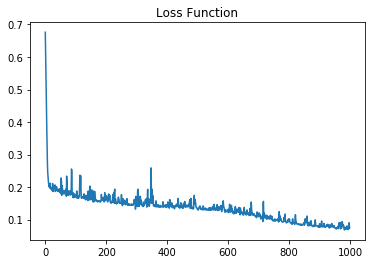

In [21]:
plt.title("Loss Function")
plt.plot(history.history['loss'])
plt.show()

### (3) 테스트셋에 적용하기

In [22]:
test_x = test_df[['tumor_size','age']].values
test_y = test_df.label.values

In [23]:
test_y_pred = model.predict(test_x)

## 2. 다양한 종류의 평가 지표들

학습한 모델의 성능을 평가하는 기준들은 다양합니다. 주어진 문제 상황에 맞게, 모델을 어떤 기준으로 평가할 수 있을지 설계할 수 있어야 합니다. 먼저 평가 결과를 데이터 프레임으로 만들어 봅시다. 

In [24]:
# 평가 결과에 대한 데이터 프레임 만들기
result_df = pd.DataFrame({
    "label" : test_y,
    "prediction" : test_y_pred[...,0]}
)
result_df.head()

,label,prediction
0,1.0,0.435073
1,0.0,0.000932
2,0.0,0.000388
3,1.0,0.999996
4,1.0,0.998008


0번 데이터의 예측값은 0.435이고, 1번 데이터의 예측 값은 0.000932입니다. 결과를 1(True)로 보는 기준을 0.5로 설정한다면, 0번 데이터와 1번 데이터 모두 False로 예측된 것과 같아집니다. 

In [25]:
# cut-value를 0.5라 지정했을 때 결과
labels = (result_df
          .label
          .apply(lambda x: True if x>0.5 else False))
predictions = (result_df
               .prediction
               .apply(lambda x: True if x>0.5 else False))

pd.concat([labels,predictions],axis=1).head(5)

,label,prediction
0,True,False
1,False,False
2,False,False
3,True,True
4,True,True


위 결과를 보고 모델이 잘 만들어졌다고 할 수 있을까요? 분류모델을 평가하는 방법은 매우 다양합니다. 어떤 관점에서 모델의 결과를 해석하냐에 따라 모델의 성능 개선 방향이 달라질 수도 있습니다. 

기본적으로 분류모델의 결과는 맞다(True)와 아니다(False)로 나뉩니다. 가령 문제에서는 암 환자이다(True), 암 환자가 아니다(False)로 결과가 나뉠 것입니다. 예측값과 실제값 각각 양성(True)와 음성(False)의 값을 가질 수 있기 때문에 경우의 수는 총 4가지가 될 수 있습니다. 먼저 양성으로 예측된 경우를 생각해봅시다. 양성으로 예측했는데 실제 양성인 경우(True Positive, TP), 양성으로 예측했는데 실제 음성인 경우(Flase Positive, FP)가 있을 수 있겠죠. 음성으로 예측된 경우, 실제 음성인 경우(True Negative, TN), 실제 양성인 경우(False Negative, FN)가 있을 수 있습니다.

분류모델의 예측 결과 나올 수 있는 4가지 경우의 수를 표로 나타낸 것이 바로 Confusion Matrix입니다. Confusion Matrix는 분류 모델의 성능을 평가하기 위한 가장 기본이 되는 행렬입니다. 

![Imgur](https://i.imgur.com/9uGE2UL.png)

앞서 예측한 결과를 이용해 각각의 경우가 얼마나 되는지 알아봅시다.

In [26]:
TP = np.sum(labels & predictions)
FN = np.sum(labels & (~predictions))
FP = np.sum((~labels) & predictions)
TN = np.sum((~labels) & (~predictions))

In [27]:
print("(TP,FN,FP,TN) : ({},{},{},{})".format(TP,FN,FP,TN))

(TP,FN,FP,TN) : (7,2,0,11)


위의 정보를 조합하여 여러가지 기준으로 모델을 평가할 수 있습니다. 

문제에 따라 예측값이 진짜일 확률에 집중해야 할 수도 있고(Accuracy), 틀릴 확률(Error Rate)에 집중해야 할 수도 있습니다. 혹은 진짜 양성 중에 양성으로 예측한 비율에 집중해야 하는 경우도 있고(Recall), 혹은 양성이라고 예측한 경우 중에 진짜 양성인 경우에 집중해야 할 수도 있습니다(Precision).  

위 결과를 조합하여 모델을 평가하는 다양한 지표를 알아봅시다.

### (1) Accuracy 

전체적으로 이 분류기가 얼마나 잘 맞추었는지를 평가할 때 쓰입니다. 전체 데이터 중에서 정답을 맞춘 비율(암 환자를 암 환자로, 정상을 정상으로 맞춘 비율)을 구합니다. 

$$
accuracy = \frac{TP+TN}{TP+FN+FP+TN}
$$

In [28]:
accuracy = (TP+TN)/(TP+FN+FP+TN)
print("정확도 : {:2.3f}%".format(accuracy*100))

정확도 : 90.000%


### (2) Error Rate

얼마나 자주 틀렸는지를 평가할 때 쓰입니다. 주로 "Error가 20% 감소하였습니다."와 같이 이야기할 때 쓰이는 수치입니다. 

위 예시에서는 전체 데이터 중에서 정상을 암 환자로, 암환자를 정상으로 예측한 비율을 구하는 것이죠.  

$$
error\ rate = \frac{FP+FN}{TP+FN+FP+TN} = 1 - accuracy
$$

In [29]:
error_rate = (FP+FN)/(TP+FN+FP+TN)
print("에러율 : {:2.3f}%".format(error_rate*100))

에러율 : 10.000%


### (3) Recall(Sensitivity, 재현율)
실제 정답 중 모델에서 올바르게 분류한 비율을 의미합니다. 위 예제에서는 실제 양성 환자 중, 모델이 올바르게 양성 환자로 예측한 비율을 의미합니다. 암세포 검출 등 생명과 관련되어 있어 True의 경우를 놓치면 안되는 분류 문제에 있어서는 Recall을 매우 높게 설정해야 합니다. 실제 암 환자를 최대한 찾아낼 수 있어야 하기 때문입니다. 

$$
recall = \frac{TP}{TP+FN}
$$

In [30]:
recall = TP/(TP+FN)
print("재현율 : {:2.3f}%".format(recall*100))

재현율 : 77.778%


### (4) Precision(정밀도)
모델이 예측한 정답 중 실제 정답의 비율을 의미합니다. 정밀도가 높을수록, False Alarm 문제가 적게 발생합니다.

$$
precision = \frac{TP}{TP+FP}
$$

In [31]:
precision = TP/(TP+FP)
print("정밀도 : {:2.3f}%".format(precision*100))

정밀도 : 100.000%


### (5) F1-Score

재현율과 정밀도는 trade-off관계에 있습니다. 이를 평균내어 단일한 값으로 평가하는 방식이 바로 F-score입니다.

$$
F = \frac{recall * precision}{recall + precision}
$$

In [32]:
F = (recall*precision)/(recall+precision)
print("F1-score : {:.3f}".format(F))

F1-score : 0.438


### (6) ROC Curve

cut value에 따라서 정밀도와 재현율의 결과는 달라지게 됩니다. 우리는 cut value에 따라 모델의 평가 결과가 어떻게 달라지는지 보여주는 그래프로 주로 **ROC Curve**를 이용합니다.

In [33]:
def calculate_tpr_and_fpr(cut_value):
    predictions = (result_df
                   .prediction
                   .apply(lambda x: True if x>=cut_value else False))
    
    TP = np.sum(labels & predictions)
    FN = np.sum(labels & (~predictions))
    FP = np.sum((~labels) & predictions)
    TN = np.sum((~labels) & (~predictions))
    
    tpr = TP/(TP+FN) # 참 양성 비율(재현율과 동일)
    fpr = FP/(FP+TN) # 허위 양성 비율
    
    return tpr, fpr

In [34]:
tpr, fpr = calculate_tpr_and_fpr(0.1)
print("cutvalue:0.1 -> tpr : {:.3f}/fpr : {:.3f}".format(tpr, fpr))

tpr, fpr = calculate_tpr_and_fpr(0.3)
print("cutvalue:0.3 -> tpr : {:.3f}/fpr : {:.3f}".format(tpr, fpr))

tpr, fpr = calculate_tpr_and_fpr(0.5)
print("cutvalue:0.5 -> tpr : {:.3f}/fpr : {:.3f}".format(tpr, fpr))


cutvalue:0.1 -> tpr : 1.000/fpr : 0.000
cutvalue:0.3 -> tpr : 1.000/fpr : 0.000
cutvalue:0.5 -> tpr : 0.778/fpr : 0.000


In [35]:
cut_values = np.linspace(0.0,1.,100)

tpr_list = []
fpr_list = []
for cut_value in cut_values:
    tpr, fpr = calculate_tpr_and_fpr(cut_value)
    tpr_list.append(tpr)
    fpr_list.append(fpr)    

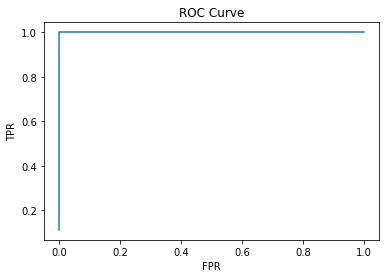

In [36]:
plt.title("ROC Curve")
plt.plot(fpr_list,tpr_list)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

### (7) AUC

AUC는 "ROC 곡선 아래 영역"을 의미합니다. 예측이 100% 잘못된 모델의 AUC는 0.0이 되고, 예측이 100% 정확한 모델의 AUC는 1.0이 됩니다. 

In [37]:
prev_fpr = fpr_list[0]
prev_tpr = tpr_list[0]

AUC = 0
for curr_fpr, curr_tpr in zip(fpr_list[1:],tpr_list[1:]):
    segment = (prev_fpr-curr_fpr)*(curr_tpr + prev_tpr)/2
    AUC += segment
    prev_fpr, prev_tpr = curr_fpr, curr_tpr
print(AUC)

1.0


#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/09/16


---